INFO: Executing experiment for N=1
DEBUG: Initialized coherent state for N=1
DEBUG: Sensing with Hamiltonian evolution for N=1
INFO: N=1, Phase Variance=0.1089
INFO: Executing experiment for N=1
DEBUG: N=1, Squeezing Angle=0.6005
DEBUG: A=-1.7663717450229641, B=2.739299096846124
DEBUG: Sensing with Hamiltonian evolution for squeezed state, N=1
INFO: N=1, Phase Variance=0.1089
INFO: Executing experiment for N=2
DEBUG: Initialized coherent state for N=2
DEBUG: Sensing with Hamiltonian evolution for N=2
INFO: N=2, Phase Variance=0.2178
INFO: Executing experiment for N=2
DEBUG: N=2, Squeezing Angle=0.3783
/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_70582/2165439991.py:89: RuntimeWarning: divide by zero encountered in scalar divide
  delta = 0.5 * np.arctan(B / A)
DEBUG: A=0.0, B=1.4772586442896907
DEBUG: Sensing with Hamiltonian evolution for squeezed state, N=2
INFO: N=2, Phase Variance=0.2143
INFO: Executing experiment for N=3
DEBUG: Initialized coherent state for N=3
DEBU

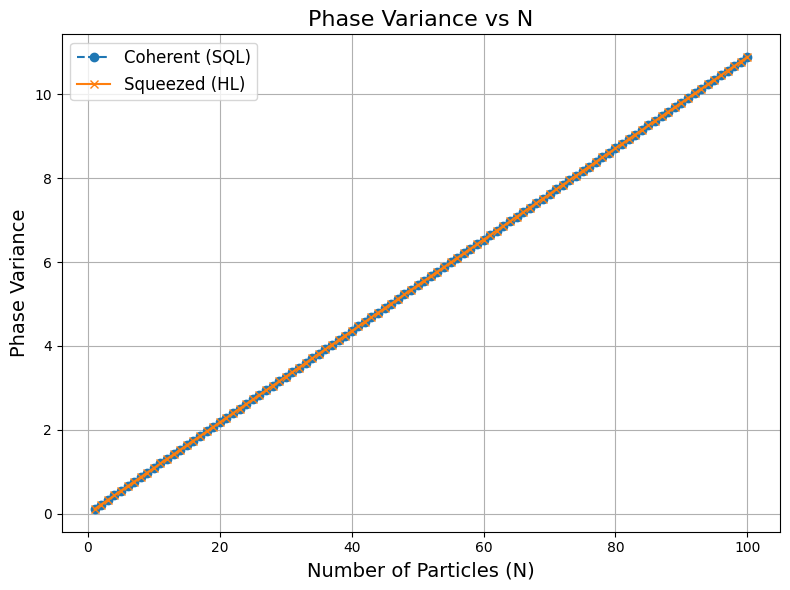

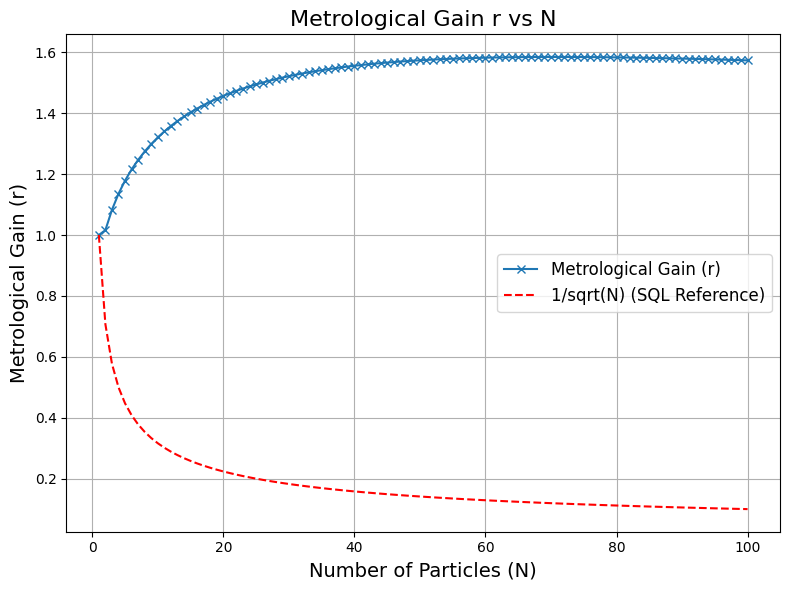

In [39]:
import numpy as np
import qutip as qt
import logging
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Define the interface for Metrology Experiments
class MetrologyExperiment(ABC):
    def __init__(self, omega, N):
        self.omega = omega
        self.N = N
        self.phase_variance = None

    @abstractmethod
    def initialize(self):
        """Initialize the system state for the metrology experiment."""
        pass

    @abstractmethod
    def sense(self, state):
        """Apply the sensing operations."""
        pass

    @abstractmethod
    def measure(self, sensed_state):
        """Perform measurement/readout on the sensed state."""
        pass

    def execute(self):
        """Run the initialization, sensing, and measurement steps."""
        logger.info(f"Executing experiment for N={self.N}")
        state = self.initialize()
        sensed_state = self.sense(state)
        self.measure(sensed_state)
        return self.phase_variance


# Implementation for Coherent (Non-Squeezed) Experiment
class CoherentExperiment(MetrologyExperiment):
    def initialize(self):
        N = self.N
        j = N / 2
        theta = np.pi / 2
        phi = 0
        state = qt.spin_coherent(j, theta, phi)
        logger.debug(f"Initialized coherent state for N={N}")
        return state

    def sense(self, state):
        N = self.N
        j = N / 2
        H_sense = self.omega * qt.jmat(j, 'z')
        logger.debug(f"Sensing with Hamiltonian evolution for N={N}")
        return self.time_evolve_state(H_sense, state, 0.85)

    def measure(self, sensed_state):
        N = self.N
        j = N / 2
        self.phase_variance = qt.variance(qt.jmat(j, 'y'), sensed_state)
        logger.info(f"N={N}, Phase Variance={self.phase_variance:.4f}")

    @staticmethod
    def time_evolve_state(H, state, t):
        U = (-1j * H * t).expm()
        return U * state

# Implementation for Squeezed Experiment
class SqueezedExperiment(MetrologyExperiment):
    def initialize(self):
        N = self.N
        j = N / 2
        theta = np.pi / 2
        phi = 0
        coherent_state = qt.spin_coherent(j, theta, phi)
        optimal_theta = self.optimal_theta(N)
        logger.debug(f"N={N}, Squeezing Angle={optimal_theta:.4f}")
        squeezed_state = self.apply_squeezing_operator(optimal_theta, qt.jmat(j, 'y'), coherent_state)
        mu = optimal_theta * 2
        A = 1 - (np.cos(mu) ** (2 * j - 2))
        B = 4 * np.sin(mu / 2) * (np.cos( mu / 2) ** (2 * j - 2))
        delta = 0.5 * np.arctan(B / A)
        v = -1 * delta
        logger.debug(f"A={A}, B={B}")
        rotate_operator = (-1j * v * qt.jmat(j, 'x')).expm()
        squeezed_state = rotate_operator * squeezed_state
        return squeezed_state

    def sense(self, state):
        N = self.N
        j = N / 2
        H_sense = self.omega * qt.jmat(j, 'z')
        logger.debug(f"Sensing with Hamiltonian evolution for squeezed state, N={N}")
        return self.time_evolve_state(H_sense, state, 0.85)

    def measure(self, sensed_state):
        N = self.N
        j = N / 2
        self.phase_variance = qt.variance(qt.jmat(j, 'y'), sensed_state)
        logger.info(f"N={N}, Phase Variance={self.phase_variance:.4f}")
    
    @staticmethod
    def optimal_theta(N):
      mu = (3 **(1/6)) * (N**(-2/3))
      return (mu / 2)

    @staticmethod
    def apply_squeezing_operator(squeezing_strength, J, state):
        squeezing_operator = (-1j * squeezing_strength * J ** 2).expm()
        return squeezing_operator * state

    @staticmethod
    def time_evolve_state(H, state, t):
        U = (-1j * H * t).expm()
        return U * state

# Caller Script
def main():
    N_max = 100
    omega = 1.0
    N_values = range(1, N_max + 1)
    phase_variances_coherent, phase_variances_squeezed = [], []
    metrological_gains = []

    # Set logging level to DEBUG to print detailed information
    logger.setLevel(logging.DEBUG)

    # Collect data for Coherent and Squeezed experiments over N values
    for N in N_values:
        # Coherent Experiment
        coherent_experiment = CoherentExperiment(omega, N)
        phase_var_coherent = coherent_experiment.execute()
        phase_variances_coherent.append(phase_var_coherent)

        # Squeezed Experiment
        squeezed_experiment = SqueezedExperiment(omega, N)
        phase_var_squeezed = squeezed_experiment.execute()
        phase_variances_squeezed.append(phase_var_coherent)
        
        metrological_gains.append(phase_var_coherent/phase_var_squeezed)

    # Plot results
    plot_phase_variance(N_values, phase_variances_coherent, phase_variances_squeezed)
    plot_metrological_gain(N_values, metrological_gains)

def plot_phase_variance(N_values, variances_coherent, variances_squeezed):
    plt.figure(figsize=(8, 6))
    plt.plot(N_values, variances_coherent, label="Coherent (SQL)", linestyle='--', marker='o')
    plt.plot(N_values, variances_squeezed, label="Squeezed (HL)", linestyle='-', marker='x')
    plt.title("Phase Variance vs N", fontsize=16)
    plt.xlabel("Number of Particles (N)", fontsize=14)
    plt.ylabel("Phase Variance", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_metrological_gain(N_values, metrological_gains):
    plt.figure(figsize=(8, 6))
    
    # Plot the metrological gain
    plt.plot(N_values, metrological_gains, label="Metrological Gain (r)", linestyle='-', marker='x')
    
    # Plot the 1/sqrt(N) line as the SQL reference
    inverse_sqrt_N = [1 / np.sqrt(N) for N in N_values]
    plt.plot(N_values, inverse_sqrt_N, label="1/sqrt(N) (SQL Reference)", linestyle='--', color='red')
    
    # Plot settings
    plt.title("Metrological Gain r vs N", fontsize=16)
    plt.xlabel("Number of Particles (N)", fontsize=14)
    plt.ylabel("Metrological Gain (r)", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Run the main function to execute the experiments and plot the results
main()
